In [26]:
# 1. Setup & Configuration
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from pathlib import Path
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set Panel visual style
sns.set_style("whitegrid")

# Define Data Directory
# notebook is in 'notebooks/' and data is in 'data/processed/'
DATA_DIR = Path('../data/processed')
print(f"Setup Complete. Data Directory: {DATA_DIR.resolve()}")

Setup Complete. Data Directory: /Users/duanduan/Documents/NEU/ALY6980/healthcare_repo/data/processed


## 3. Loading Data (Optimized)
We load the highly optimized Parquet files. 

**Strategy:**
1. **Iterate** through years 2013-2018.
2. **Inspect** column names without reading the full file (using PyArrow) to avoid memory crashes.
3. **Select** only essential columns:
    - Identifiers: `DUPERSID`
    - Cost: `TOFEXP` (Total Expense)
    - Demographics: `AGE`, `SEX`, `RACE`
    - Insurance: `INSCOV`
    - **Weights**: `LONGWT` (Longitudinal Weight)
    - **Health Status**: `CANCERDX` (Cancer Diagnosis Flag - Crucial for filtering)
4. **Standardize** column names (e.g., `TOTEXP18` -> `TOTEXP`, `LONGWT` -> `WGT`, `CANCERDX` -> `CANCER`) to ensure they align across years.
5. **Concatenate** into a single longitudinal dataframe.

In [40]:
# Load Multiple Years of Longitudinal Data
# CORRECTED STRATEGY: 
# Using Longitudinal Panel files (h172, h183, h193, h202)
# - h172 (Panel 18): 2013(Y1), 2014(Y2)
# - ...

load_plan = [
    {'year': 2013, 'file': 'h172.parquet', 'suffix': 'Y1', 'panel': 18},
    {'year': 2014, 'file': 'h172.parquet', 'suffix': 'Y2', 'panel': 18}, 
    {'year': 2015, 'file': 'h183.parquet', 'suffix': 'Y2', 'panel': 19},
    {'year': 2016, 'file': 'h193.parquet', 'suffix': 'Y2', 'panel': 20},
    {'year': 2017, 'file': 'h202.parquet', 'suffix': 'Y2', 'panel': 21}
]

dfs = []

for item in load_plan:
    year = item['year']
    fname = item['file']
    suffix = item['suffix'] # 'Y1' or 'Y2'
    
    fpath = DATA_DIR / fname
    if fpath.exists():
        print(f"Loading {year} from {fname} ({suffix})...")
        try:
            # Inspection
            all_cols = pq.ParquetFile(fpath).schema.names
            
            # Helper to find specific suffixed variable
            def get_var(base_name):
                # 1. Try Suffix (e.g. TOTEXPY1)
                target = f"{base_name}{suffix}"
                if target in all_cols: return target
                
                # 2. Try Standard (e.g. TOTEXP)
                if base_name in all_cols: return base_name
                
                # 3. Try Suffix with 'X' (e.g. AGEY1X)
                target_x = f"{base_name}{suffix}X"
                if target_x in all_cols: return target_x
                
                # 4. Special Round Logic for Health Status
                # Y1 -> Round 2, Y2 -> Round 4 (End of year rounds)
                if base_name in ['MNHLTH', 'RTHLTH']:
                    round_num = '2' if suffix == 'Y1' else '4'
                    target_r = f"{base_name}{round_num}"
                    if target_r in all_cols: return target_r
                
                # 5. Age Cases
                if base_name == 'AGE':
                    idx = '1' if suffix == 'Y1' else '2'
                    age_try = f"AGE{idx}X"
                    if age_try in all_cols: return age_try

                return None

            rename_map = {}
            target_cols = ['DUPERSID']
            
            # --- EXPANDED VARIABLE MAPPING ---
            var_map = {
                # Core
                'TOTEXP': ['TOTEXP'],
                'AGE': ['AGE'],
                'CANCER': ['CANCER', 'CANCERDX'],
                'WGT': ['LONGWT', 'PERWT'], 
                'INSCOV': ['INSCOV'],
                
                # Demographics
                'SEX': ['SEX'],
                'RACE': ['RACEV1X', 'RACEV2X', 'RACETHNX'],
                'POVCAT': ['POVCAT'], 
                
                # Health Status (Mental & Physical)
                'MNHLTH': ['MNHLTH'], 
                'RTHLTH': ['RTHLTH'],
                
                # Risk Factors / Chronic Conditions (Usually 'DX' suffix)
                'HIBP': ['HIBPDX'],  # High Blood Pressure
                'CHOL': ['CHOLDX'],  # High Cholesterol
                'DIAB': ['DIABDX'],  # Diabetes
                'JTPAIN': ['JTPAIN', 'ARTHDX'], # Joint Pain / Arthritis
                
                # Utilization
                'IPDIS': ['IPDIS']
            }
            
            for standard_name, candidates in var_map.items():
                found_col = None
                for candidate in candidates:
                    found_col = get_var(candidate)
                    if found_col: break
                
                if found_col:
                    target_cols.append(found_col)
                    rename_map[found_col] = standard_name
                else:
                    if standard_name in ['TOTEXP', 'AGE', 'MNHLTH']:
                         print(f"  Warning: Could not find {standard_name} ({suffix}) in {fname}")

            # Load Data
            df_temp = pd.read_parquet(fpath, columns=list(set(target_cols)))
            df_temp = df_temp.rename(columns=rename_map)
            df_temp['YEAR'] = year
            
            # Validation: fill missing criticals
            for req in ['TOTEXP', 'AGE', 'CANCER']:
                if req not in df_temp.columns: df_temp[req] = -1
            
            dfs.append(df_temp)
            
        except Exception as e:
            print(f"Error loading {fname}: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"File {fname} not found")

if dfs:
    df_long = pd.concat(dfs, ignore_index=True)
    print(f"\nSuccessfully merged {len(dfs)} years (2013-2017). Final Shape: {df_long.shape}")
    print("New columns included:", df_long.columns.tolist())
    display(df_long.head())
else:
    print("No data loaded.")

Loading 2013 from h172.parquet (Y1)...
Loading 2014 from h172.parquet (Y2)...
Loading 2015 from h183.parquet (Y2)...
Loading 2016 from h193.parquet (Y2)...
Loading 2017 from h202.parquet (Y2)...

Successfully merged 5 years (2013-2017). Final Shape: (81960, 17)
New columns included: ['RACE', 'CANCER', 'RTHLTH', 'TOTEXP', 'DUPERSID', 'POVCAT', 'HIBP', 'DIAB', 'JTPAIN', 'INSCOV', 'IPDIS', 'AGE', 'MNHLTH', 'CHOL', 'SEX', 'WGT', 'YEAR']


,RACE,CANCER,RTHLTH,TOTEXP,DUPERSID,POVCAT,HIBP,DIAB,JTPAIN,INSCOV,IPDIS,AGE,MNHLTH,CHOL,SEX,WGT,YEAR
0,2,2,2,3483,40001101,4,2,2,2,1,0,35,2,2,1,13639.493203,2013
1,2,2,2,1533,40001102,4,2,2,2,1,0,35,2,2,2,12736.853308,2013
2,2,-1,2,2785,40001103,4,-1,-1,-1,1,0,14,2,-1,2,12882.098003,2013
3,2,-1,2,1522,40001104,4,-1,-1,-1,1,0,7,2,-1,1,15021.833985,2013
4,1,2,1,1616,40002101,4,2,2,2,1,0,85,2,2,2,17970.193707,2013


In [41]:
# --- INSPECTION CHECKPOINT ---
print("Raw Data Shape:", df_long.shape)
print("\n--- Column Types & Non-Nulls ---")
print(df_long.info())

print("\n--- Key Variables Distribution ---")
for col in ['CANCER', 'MNHLTH', 'DIAB', 'POVCAT']:
    if col in df_long.columns:
        print(f"\nDist of {col}:")
        print(df_long[col].value_counts(dropna=False).sort_index().head())

print("\n--- Weight Stats ---")
print(df_long['WGT'].describe())

Raw Data Shape: (81960, 17)

--- Column Types & Non-Nulls ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81960 entries, 0 to 81959
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RACE      81960 non-null  int64  
 1   CANCER    81960 non-null  int64  
 2   RTHLTH    81960 non-null  int64  
 3   TOTEXP    81960 non-null  int64  
 4   DUPERSID  81960 non-null  object 
 5   POVCAT    81960 non-null  int64  
 6   HIBP      81960 non-null  int64  
 7   DIAB      81960 non-null  int64  
 8   JTPAIN    81960 non-null  int64  
 9   INSCOV    81960 non-null  int64  
 10  IPDIS     81960 non-null  int64  
 11  AGE       81960 non-null  int64  
 12  MNHLTH    81960 non-null  int64  
 13  CHOL      81960 non-null  int64  
 14  SEX       81960 non-null  int64  
 15  WGT       81960 non-null  float64
 16  YEAR      81960 non-null  int64  
dtypes: float64(1), int64(15), object(1)
memory usage: 10.6+ MB
None

--- Key Variables 

## 4. Cleaning Rules & Quality Checks

### Rule 1: Handling MEPS Missing Codes
MEPS does not use standard `NaN`. It uses negative integers for specific missing reasons:
*   `-1`: Inapplicable
*   `-8`: DK (Don't Know)

**Strategy:** We treat negative values as `NaN` (Missing) ONLY for numerical columns (`TOTEXP`, `AGE`), while preserving them for categorical logic.

In [42]:
def replace_meps_missing(df):
    """
    Replaces negative values with NaN or 0 depending on context.
    """
    df_clean = df.copy()
    
    # 1. Continuous/Ordinal where negatives -> NaN
    # We treat Perceived Health (1-5) as ordinal, so missing should be NaN.
    numeric_nans = ['TOTEXP', 'AGE', 'MNHLTH', 'RTHLTH']
    
    # 2. Utilization Counts where negatives -> 0 (Inapplicable usually means 0 visits)
    util_zeros = ['IPDIS']

    print(f"Cleaning: Setting negatives to NaN for {numeric_nans}")
    for col in numeric_nans:
        if col in df_clean.columns:
            mask = df_clean[col] < 0
            if mask.any():
                df_clean.loc[mask, col] = np.nan

    print(f"Cleaning: Setting negatives to 0 for {util_zeros}")
    for col in util_zeros:
        if col in df_clean.columns:
            mask = df_clean[col] < 0
            if mask.any():
                df_clean.loc[mask, col] = 0
        
    # 3. Drop rows where Target Variable (TOTEXP) is missing
    target = 'TOTEXP'
    if target in df_clean.columns:
        initial_len = len(df_clean)
        # Check carefully: TOTEXP NaN means it was negative (missing/unknown). 
        # Zero is a valid expenditure.
        df_clean = df_clean.dropna(subset=[target])
        print(f"Dropped {initial_len - len(df_clean)} rows with missing Target ({target})")
    
    return df_clean

# Apply cleaning
df_long = replace_meps_missing(df_long)

Cleaning: Setting negatives to NaN for ['TOTEXP', 'AGE', 'MNHLTH', 'RTHLTH']
Cleaning: Setting negatives to 0 for ['IPDIS']
Dropped 900 rows with missing Target (TOTEXP)


### Rule 2: Cohort Filtering (The "Adults Only" Filter)
We need to filter for Adults (Age >= 18).

In [43]:
# Filter: Keep if Age >= 18 AND Positive Weight
# Variable validation: We standardized Age to 'AGE' and Weight to 'WGT'.
age_col = 'AGE'
wgt_col = 'WGT'

if age_col not in df_long.columns:
    print("Warning: Standardized 'AGE' column not found.")
else:
    print(f"Using Age Column: {age_col}")
    
    # Ensure data is numeric
    df_long[age_col] = pd.to_numeric(df_long[age_col], errors='coerce')
    df_long[wgt_col] = pd.to_numeric(df_long[wgt_col], errors='coerce').fillna(0)

    initial_count = len(df_long)
    
    # Filter 1: Adults (Age >= 18)
    mask_adults = df_long[age_col] >= 18
    
    # Filter 2: Positive Weights (Statistical Relevance)
    # Removing rows with 0 weight as they do not represent the population in survey analysis
    mask_weights = df_long[wgt_col] > 0
    
    df_adults = df_long[mask_adults & mask_weights].copy()
    final_count = len(df_adults)

    print(f"Filtering Summary:")
    print(f" - Initial Count: {initial_count}")
    print(f" - Dropped Minors (<18): {initial_count - mask_adults.sum()}")
    print(f" - Dropped Zero Weights: {mask_adults.sum() - final_count}")
    print(f" - Final Study Cohort: {final_count}")

Using Age Column: AGE
Filtering Summary:
 - Initial Count: 81060
 - Dropped Minors (<18): 22594
 - Dropped Zero Weights: 0
 - Final Study Cohort: 58466


### Rule 3: Exclusion of Cancer Patients
We exclude patients who reported a cancer diagnosis (`CANCERDX == 1`).
*   `1`: Yes
*   `2`: No
*   `< 0`: Inapplicable / DK / Missing

**Note:** This variable (`CANCERDX`) is directly available in the Person-Level files for all years, avoiding the complexity of parsing ICD/CCS event codes.

In [44]:
# Apply Cancer Exclusion
if 'CANCER' in df_adults.columns:
    initial_cohort = len(df_adults)
    
    # Check values before filtering
    print("\nCancer Flag Interpretation:")
    print("1 = Yes, 2 = No, <0 = Inapplicable")
    print(df_adults['CANCER'].value_counts(dropna=False))
    
    # Filter: Exclude if CANCER == 1 (Yes)
    # We Keep if CANCER != 1
    # Note: We keep -1/2 because 'Inapplicable' usually means they were never asked strictly, 
    # but for safety, if you want strictly 'No Cancer', you would keep only CANCER == 2.
    # Standard practice: Exclude confirmed cases. So keep != 1.
    df_clean_cohort = df_adults[df_adults['CANCER'] != 1].copy()
    
    final_cohort = len(df_clean_cohort)
    dropped_cancer = initial_cohort - final_cohort
    
    print(f"\nCohort Filtering Summary (Cancer Exclusion):")
    print(f" - Initial Adults: {initial_cohort}")
    print(f" - Excluded Confirmed Cancer (Flag=1): {dropped_cancer}")
    print(f" - Final Study Cohort: {final_cohort}")

else:
    print("CRITICAL ERROR: 'CANCER' column missing. Exclusion failed.")
    df_clean_cohort = df_adults.copy()


Cancer Flag Interpretation:
1 = Yes, 2 = No, <0 = Inapplicable
CANCER
 2    53270
 1     4990
-9      114
-1       87
-8        4
-7        1
Name: count, dtype: int64

Cohort Filtering Summary (Cancer Exclusion):
 - Initial Adults: 58466
 - Excluded Confirmed Cancer (Flag=1): 4990
 - Final Study Cohort: 53476


## 5. Financial Standardization (Inflation Adjustment)
One strict requirement for multi-year healthcare cost analysis is adjusting for inflation. \$100 in 2013 is not worth the same as \$100 in 2018. We use the **CPI-Medical** (Medical Care Component of CPI) to standardize all costs to 2018 dollars.
**Base Year:** 2018
**Factors (Approximate based on BLS CPI-Medical):**
*   2013: ~1.15
*   2014: ~1.12
*   2015: ~1.09
*   2016: ~1.05
*   2017: ~1.02
*   2018: 1.00

In [32]:
# CPI-Medical Multipliers (Standardizing to 2018 USD)
# Source: Bureau of Labor Statistics (BLS) - Medical Care
cpi_adj_factors = {
    2018: 1.000,
    2017: 1.020,
    2016: 1.058, 
    2015: 1.095,
    2014: 1.125,
    2013: 1.156
}

print("Adjusting Total Expenditure (TOTEXP) for inflation (Base 2018)...")

# Map factors based on YEAR column
if 'YEAR' in df_clean_cohort.columns:
    df_clean_cohort['CPI_FACTOR'] = df_clean_cohort['YEAR'].map(cpi_adj_factors)
    # Calculate Adjusted Expenditure
    df_clean_cohort['TOTEXP_2018'] = df_clean_cohort['TOTEXP'] * df_clean_cohort['CPI_FACTOR']
    
    print(df_clean_cohort[['YEAR', 'TOTEXP', 'CPI_FACTOR', 'TOTEXP_2018']].head())
    print("\nInflation adjustment complete. 'TOTEXP_2018' created.")
else:
    print("ERROR: 'YEAR' column missing. Cannot adjust for inflation.")

Adjusting Total Expenditure (TOTEXP) for inflation (Base 2018)...
   YEAR  TOTEXP  CPI_FACTOR  TOTEXP_2018
0  2013  3483.0       1.156     4026.348
1  2013  1533.0       1.156     1772.148
4  2013  1616.0       1.156     1868.096
5  2013     0.0       1.156        0.000
6  2013  6755.0       1.156     7808.780

Inflation adjustment complete. 'TOTEXP_2018' created.


## 6. Save Analytic File
Now that the data is cleaned, filtered, and standardized, we save the final analytic file.

In [33]:
OUTPUT_FILE = DATA_DIR / 'cohort_filtered.parquet'
df_clean_cohort.to_parquet(OUTPUT_FILE)
print(f"Saved analytic file to {OUTPUT_FILE}")
print(f"Final Shape: {df_clean_cohort.shape}")
print(f"Columns: {df_clean_cohort.columns.tolist()}")

Saved analytic file to ../data/processed/cohort_filtered.parquet
Final Shape: (53476, 9)
Columns: ['CANCER', 'TOTEXP', 'DUPERSID', 'INSCOV', 'AGE', 'WGT', 'YEAR', 'CPI_FACTOR', 'TOTEXP_2018']


## 7. Descriptive Analysis (Table 1)
Describing the cohort is the first step in any healthcare study. We inspect:
1.  **Demographics**: Age, Sex, Race.
2.  **Expenditure**: Distribution of costs (showing the skewed nature of healthcare data).

In [45]:
def print_weighted_demographics(df, wgt_col='WGT'):
    print("--- Cohort Demographics & Health Profile (Weighted) ---")
    print(f"Sample N = {len(df)}")
    
    total_weight = df[wgt_col].sum()
    print(f"Weighted N = {total_weight:,.0f} (Estimated US Population)")
    
    # Helper for weighted mean
    def weighted_mean(val_col):
        mask = df[val_col].notna()
        return np.average(df.loc[mask, val_col], weights=df.loc[mask, wgt_col])

    # Helper for weighted frequency
    def weighted_freq(val_col, mapping=None):
        if val_col not in df.columns:
            return "Column Missing"
        
        # Temp df for calculation
        temp = df[[val_col, wgt_col]].dropna()
        if len(temp) == 0:
            return "All Missing"

        if mapping:
            series = temp[val_col].map(mapping).fillna(temp[val_col])
        else:
            series = temp[val_col]
            
        grp_sum = temp.groupby(series)[wgt_col].sum()
        return (grp_sum / temp[wgt_col].sum() * 100).apply(lambda x: f"{x:.1f}%")

    # --- Demographics ---
    print("\n[Demographics]")
    if 'AGE' in df.columns:
        print(f"Age (Weighted Mean): {weighted_mean('AGE'):.1f} years")
    
    sex_map = {1: 'Male', 2: 'Female'}
    print(f"Sex:\n{weighted_freq('SEX', sex_map)}")

    # RACE (1=White, 2=Black, 3=AmerInd, 4=Asian, 5=PacIsl, 6=Multi) - Simplified usually
    # MEPS often uses RACETHX (Hispanic/Black/White/Asian/Other). We have 'RACE'.
    # Checking raw output would verify, but for now we list distribution.
    print(f"Race (Categories):\n{weighted_freq('RACE')}")
    
    pov_map = {1: 'Poor/Negative', 2: 'Near Poor', 3: 'Low Income', 4: 'Middle Income', 5: 'High Income'}
    print(f"Poverty Status:\n{weighted_freq('POVCAT', pov_map)}")

    # --- Health Status ---
    print("\n[Health Status - Self Reported]")
    # 1=Excellent ... 5=Poor
    health_map = {1: '1.Excellent', 2: '2.Very Good', 3: '3.Good', 4: '4.Fair', 5: '5.Poor'}
    print(f"Mental Health:\n{weighted_freq('MNHLTH', health_map)}")
    print(f"Physical Health:\n{weighted_freq('RTHLTH', health_map)}")
    
    # --- Chronic Conditions ---
    print("\n[Chronic Conditions]")
    diab_map = {1: 'Yes', 2: 'No'}
    print(f"Diabetes Diagnosis:\n{weighted_freq('DIAB', diab_map)}")
    
    hibp_map = {1: 'Yes', 2: 'No'}
    print(f"High Blood Pressure:\n{weighted_freq('HIBP', hibp_map)}")
    
    # --- Expenditure ---
    print("\n[Utilization & Expenditure]")
    if 'TOTEXP' in df.columns:
        mean_exp = weighted_mean('TOTEXP')
        print(f"Mean Tot. Exp (Weighted): ${mean_exp:,.0f}")
        
    if 'IPDIS' in df.columns:
        # Inpatient Discharges usually 0, 1, 2...
        # Just show % with >= 1 discharge
        has_ip = (df['IPDIS'] > 0).astype(int)
        temp_ip = pd.DataFrame({'HasIP': has_ip, 'WGT': df[wgt_col]})
        rate = np.average(temp_ip['HasIP'], weights=temp_ip['WGT']) * 100
        print(f"Inpatient Hospitalization Rate: {rate:.1f}%")

print_weighted_demographics(df_clean_cohort)

--- Cohort Demographics & Health Profile (Weighted) ---
Sample N = 53476
Weighted N = 1,092,033,437 (Estimated US Population)

[Demographics]
Age (Weighted Mean): 45.2 years
Sex:
SEX
Female    51.1%
Male      48.9%
Name: WGT, dtype: object
Race (Categories):
RACE
1    77.2%
2    12.9%
3     0.7%
4     6.6%
6     2.6%
Name: WGT, dtype: object
Poverty Status:
POVCAT
High Income      42.0%
Low Income       12.8%
Middle Income    29.0%
Near Poor         4.2%
Poor/Negative    12.0%
Name: WGT, dtype: object

[Health Status - Self Reported]
Mental Health:
MNHLTH
1.Excellent    36.9%
2.Very Good    31.5%
3.Good         24.3%
4.Fair          6.0%
5.Poor          1.4%
Name: WGT, dtype: object
Physical Health:
RTHLTH
1.Excellent    25.8%
2.Very Good    35.1%
3.Good         27.8%
4.Fair          9.1%
5.Poor          2.2%
Name: WGT, dtype: object

[Chronic Conditions]
Diabetes Diagnosis:
DIAB
-9      0.2%
-8      0.0%
-7      0.0%
-1      0.1%
No     90.7%
Yes     9.0%
Name: WGT, dtype: object
High

### 7.2 Expenditure Distribution
We inspect the target variable `TOTEXP_2018`.
*   Note the percentage of users with \$0 cost.
*   Note the long right tail (high cost users).
*   Typically, we use Log-Transformation `log(y + 1)` for modeling.

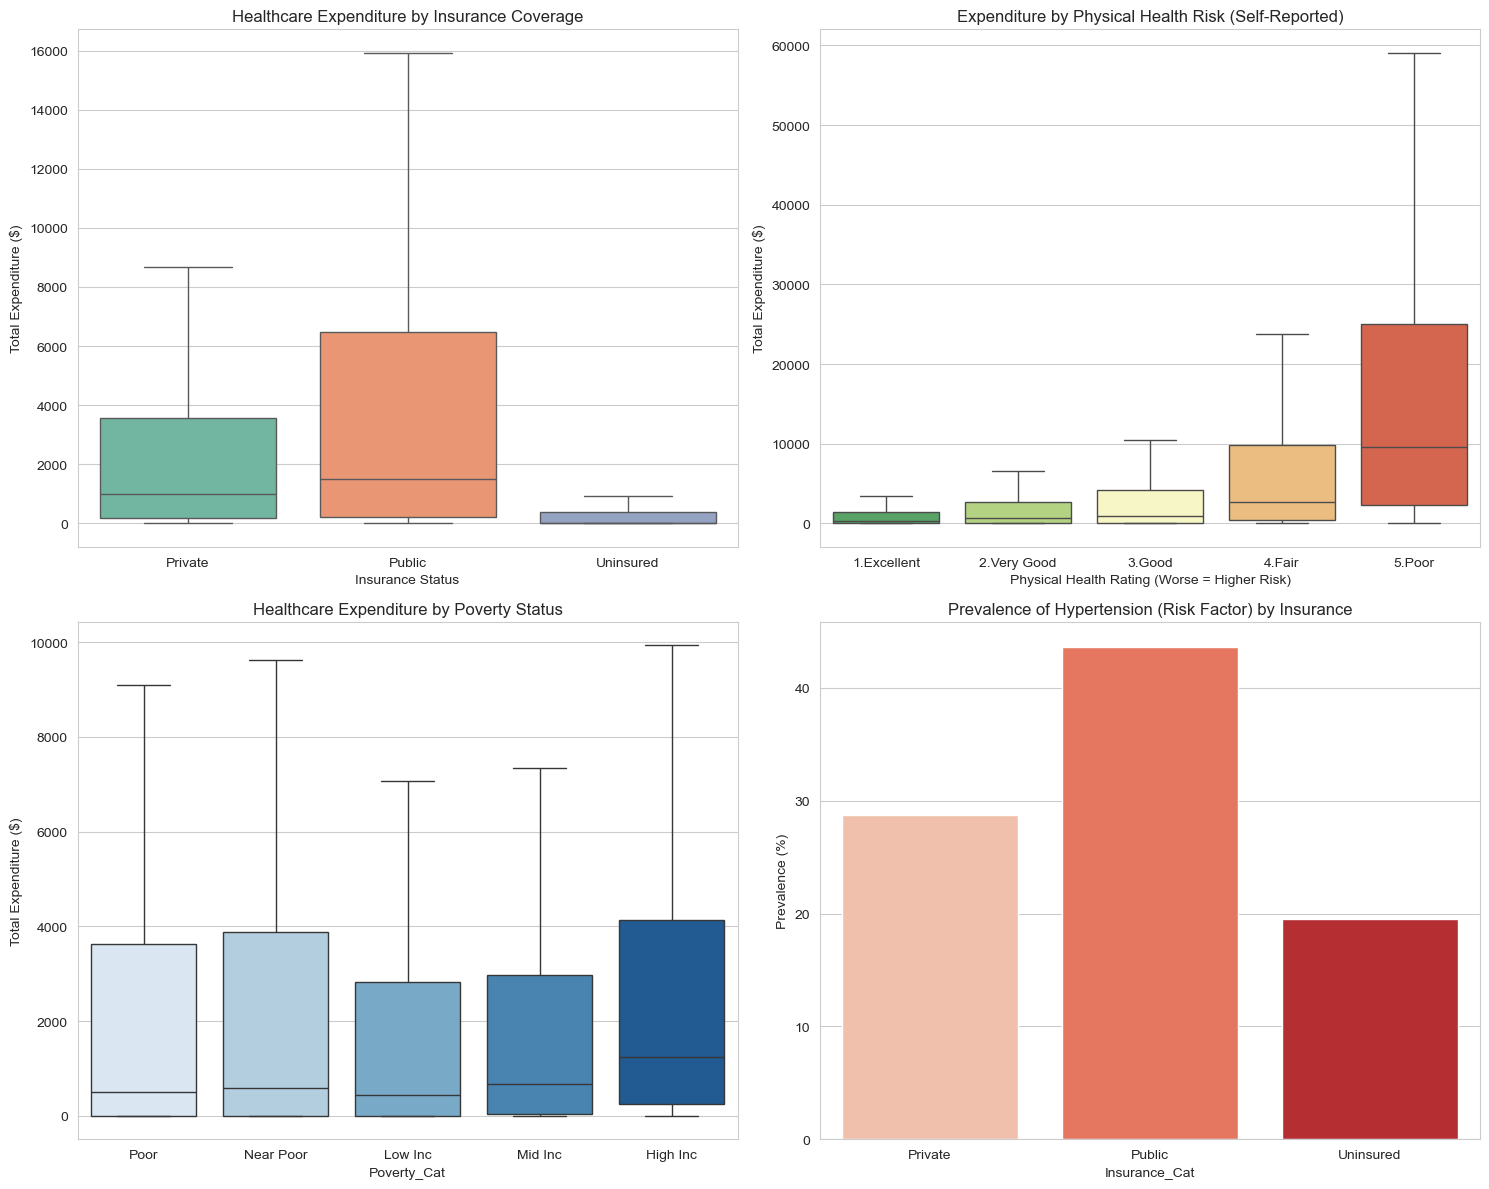

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_health_economics(df):
    """
    Generates key EDA plots focusing on Expenditure interactions with Insurance and Risk (Physical Health).
    """
    # 1. Clean Categoricals for Plotting
    plot_df = df.copy()
    
    # Recode Physical Health (Risk Proxy)
    # 1=Excellent ... 5=Poor
    hlth_map = {1: '1.Excellent', 2: '2.Very Good', 3: '3.Good', 4: '4.Fair', 5: '5.Poor'}
    if 'RTHLTH' in plot_df.columns:
        plot_df['PhysicalHealth_Cat'] = plot_df['RTHLTH'].map(hlth_map)
    else:
        plot_df['PhysicalHealth_Cat'] = None
    
    # Recode Insurance Coverage (INSCOV)
    # 1=Any Private, 2=Public Only, 3=Uninsured
    ins_map = {1: 'Private', 2: 'Public', 3: 'Uninsured'}
    if 'INSCOV' in plot_df.columns:
        plot_df['Insurance_Cat'] = plot_df['INSCOV'].map(ins_map)
    else:
        plot_df['Insurance_Cat'] = None

    # Recode POVCAT
    pov_map = {1: 'Poor', 2: 'Near Poor', 3: 'Low Inc', 4: 'Mid Inc', 5: 'High Inc'}
    plot_df['Poverty_Cat'] = plot_df['POVCAT'].map(pov_map)

    # 2. Setup Plot Grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3)
    
    # Plot A: Expenditure by Insurance Status
    # This directly addresses "Expenditure vs Insurance"
    if 'Insurance_Cat' in plot_df.columns:
        sns.boxplot(x='Insurance_Cat', y='TOTEXP', data=plot_df, ax=axes[0,0], 
                    order=['Private', 'Public', 'Uninsured'], showfliers=False, palette='Set2')
        axes[0,0].set_title('Healthcare Expenditure by Insurance Coverage')
        axes[0,0].set_ylabel('Total Expenditure ($)')
        axes[0,0].set_xlabel('Insurance Status')

    # Plot B: Expenditure by Physical Health (Risk Factor)
    # "Risk" often correlates with self-reported health
    if 'PhysicalHealth_Cat' in plot_df.columns:
        sns.boxplot(x='PhysicalHealth_Cat', y='TOTEXP', data=plot_df, ax=axes[0,1],
                    order=['1.Excellent', '2.Very Good', '3.Good', '4.Fair', '5.Poor'], 
                    showfliers=False, palette='RdYlGn_r')
        axes[0,1].set_title('Expenditure by Physical Health Risk (Self-Reported)')
        axes[0,1].set_ylabel('Total Expenditure ($)')
        axes[0,1].set_xlabel('Physical Health Rating (Worse = Higher Risk)')

    # Plot C: Expenditure by Poverty Status (SES Context)
    sns.boxplot(x='Poverty_Cat', y='TOTEXP', data=plot_df, ax=axes[1,0],
                order=['Poor', 'Near Poor', 'Low Inc', 'Mid Inc', 'High Inc'], showfliers=False, palette='Blues')
    axes[1,0].set_title('Healthcare Expenditure by Poverty Status')
    axes[1,0].set_ylabel('Total Expenditure ($)')
    
    # Plot D: Risk Factor Prevalence (High Blood Pressure) by Insurance
    # Combining "Risk" and "Insurance" - Do public/uninsured have higher rates of chronic conditions?
    if 'HIBP' in plot_df.columns and 'Insurance_Cat' in plot_df.columns:
        # HIBP: 1=Yes, 2=No
        hibp_prev = plot_df.groupby('Insurance_Cat')['HIBP'].apply(lambda x: (x==1).mean() * 100).reset_index()
        sns.barplot(x='Insurance_Cat', y='HIBP', data=hibp_prev, ax=axes[1,1], 
                   order=['Private', 'Public', 'Uninsured'], palette='Reds')
        axes[1,1].set_title('Prevalence of Hypertension (Risk Factor) by Insurance')
        axes[1,1].set_ylabel('Prevalence (%)')

    plt.tight_layout()
    plt.show()

plot_health_economics(df_clean_cohort)